In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import keras
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Устанавливаем seed для повторяемости результатов
np.random.seed(42)

In [3]:
data = pd.read_csv('posts.csv', names=['Author', 'Text'], sep=',', header=None)
data.head()

,Author,Text
0,22211,"Надо жить у моря, Мама.\n\nAdMe.ru публикует р..."
1,22211,Памятка трейдера.\n\nВыражения и термины приме...
2,22211,"Руслан Проводников или ""Сибирский Рокки"", как ..."
3,61454,"""Выбирай платья на лето"", ""готовься к лету вме..."
4,61454,"""Спят ли мамы?""- я не знала. На такой вопрос о..."


In [4]:
#from nltk.corpus import stopwords
#stop = stopwords.words('russian')
#data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#print('Stop words have been deleted')
#data['Text'].apply(lambda x: x.replace('\n', ' '));

### Подсчет количества слов в корпусе

In [5]:
data['CountWords'] = data['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data))

Количество статей в корпусе: 98442


In [6]:
spam_list = [301557842, 184330667, 191315693, 111604181, 212846761, 278053852, 281162155, 206300456, 306859957, 19006413, 275267400, 131629784, 276695686, 227968805, 65265920, 215657793, 212066696, 281866527, 172515637, 420657548, 259904924, 103086082, 36309849, 151622711, 304407589, 304407589, 234135027, 330779808, 135431520, 326927985, 22070189, 16497456, 22070189, 16497456, 120772826, 181255568, 24655736, 90966607, 102977537, 317336618, 189704404, 11663845, 57439210, 163452787, 38680483, 121144040, 211289578, 280155968, 198528079, 277512341, 33152119, 314327791, 229101154, 271546215, 4121239, 59729051, 288393060, 17620663, 296431137, 320666372, 153340241, 13309210, 333014765, 24595847, 152263680, 135815313, 27763994, 34902711, 200488318, 393710429, 400853612, 18091069, 232368999, 243123251, 159034443, 101820061, 334397479, 36372315, 18412482, 362494239, 98538332, 94983825, 171941220, 35386477, 179364423, 136668179, 57446172, 288223392, 321431512, 277994902, 190694040, 325021098, 129392296, 289027630, 216216545, 75884932, 208023062, 185965346, 2857932, 2574325, 154034429, 312715518, 286913827, 336049060, 163410643, 309938895, 372204020, 400615680, 235441786, 8391421, 136997064, 174934251, 173179778, 134275738, 93070783, 403039516, 326194938, 26960550, 18090797, 15931375, 64401851, 14665799, 223678239, 1963998, 252135842, 16352364, 386230491, 135103805, 335233013, 226605259] 
print(len(spam_list))
lam = lambda row: row['Author'] not in spam_list
data = data[data.apply(lam, axis=1)]

130


In [7]:
author_count_news = data.Author.value_counts()
print('Количество авторов в корпусе:', len(author_count_news))
#print(author_count_news[:-8300: -1])
#author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

Количество авторов в корпусе: 8479


### Количество статей у каждого пользователя

In [8]:
num_classes = 50
skip_person = 2
author_count_news = author_count_news[skip_person:skip_person + num_classes]

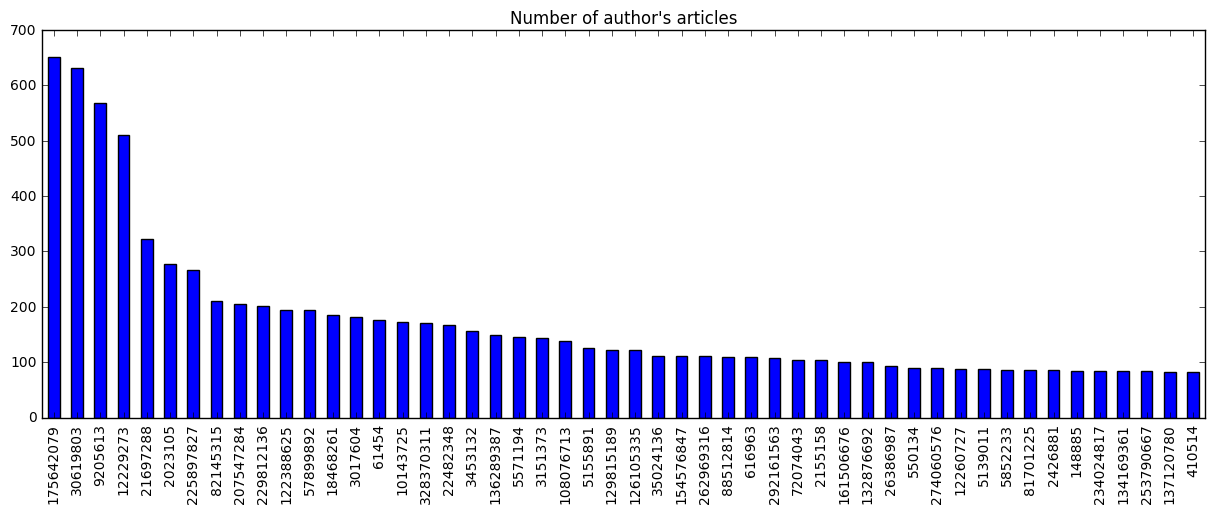

In [9]:
author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

In [9]:
#author_count_news

In [10]:
#data[data.Author == 226605259                          ]    

### Подготовка данных

In [11]:
temp_data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    temp_data = temp_data.append(data[data.Author == author])

data = temp_data
print('Количество статей после удаления:', len(data))

Количество статей после удаления: 8664


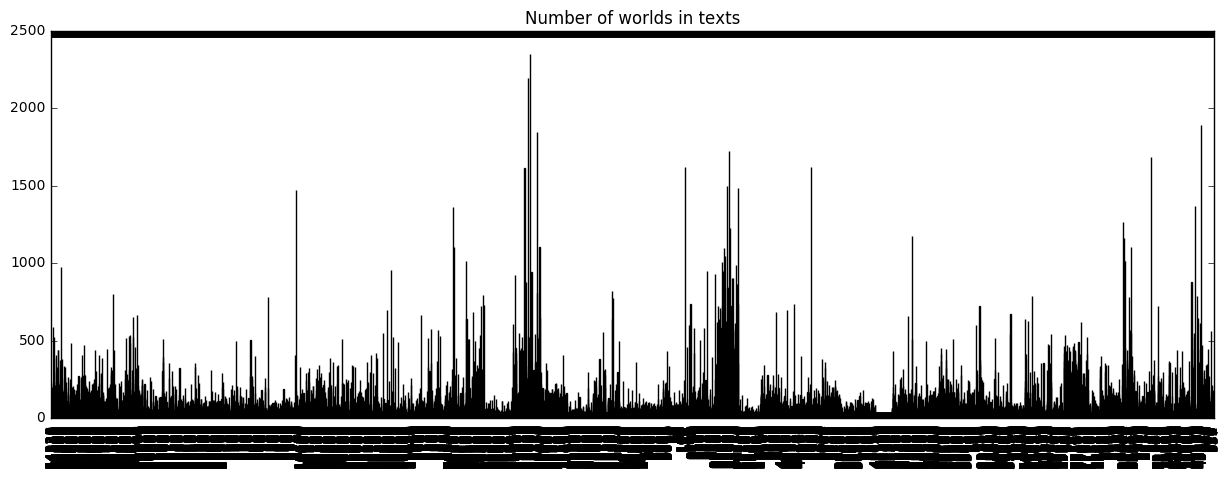

In [11]:
data.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

In [12]:
def remove_stopwords(data):
    from nltk.corpus import stopwords
    stop = stopwords.words('russian')
    data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
    print('Stop words have been deleted')

In [13]:
def get_lemmatization_corpus(data):
    import pymorphy2
    morph = pymorphy2.MorphAnalyzer()
    data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
    print('The lemmatization completed')

In [14]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data.head()

,Author,Text,CountWords
54323,40,"- А пойдемте гулять, Саша?\n- А пойдемте....😂\...",218
54324,40,- Вы думали когда-то о собственном бизнесе?\n-...,107
54325,40,"- Моё отношение к работе и решения, которые я ...",36
54326,40,"-""Выйди на сцену"" - ""Неа), мне страшно"" - сказ...",126
54327,40,"– Сарочка, с днем рождения! И сколько вам стук...",41


In [15]:
# Перемешать набор данных и удалить index столбец
data = data.sample(frac=1).reset_index(drop=True)

### Токенизация текста

In [16]:
def get_texts_to_matrix(texts, max_features = 0):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [17]:
def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    print('В словаре {} слов'.format(len(tokenizer.word_index)))
    return text_sequences

In [18]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    gramms = {}
    counter_gramm = 0
    result = []
    temp_vector = []
    
    for text in texts:
        for i in range(len(text) - count_gramm - 1):
            gramm = text[i : i + count_gramm]
            if gramms.get(gramm) == None:
                gramms[gramm] = counter_gramm
                counter_gramm += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
        temp_vector = []
        
    print('Количество грамм в корпусе:', len(gramms))
    #count_gramm = [len(x) for x in text_threegramm]
    #num = np.array(count_gramm)
    #num.mean()
    return result

In [88]:
X = get_texts_to_matrix(data['Text'], 80000)
#X = get_texts_to_gramm_sequences(data['Text'])
#X = get_texts_to_sequences(data['Text'])

Количество текстов: 8664
Количество токенов: 80000


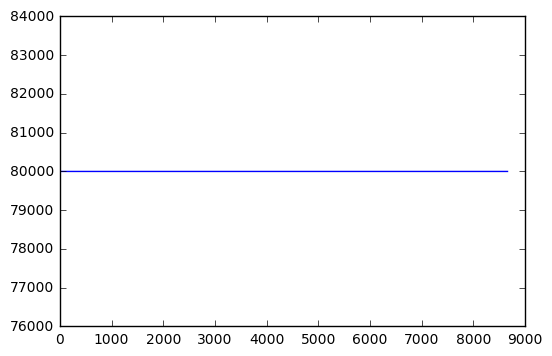

In [89]:
#plt.plot(X)
means = [len(x) for x in X]
plt.plot(means)
#X.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

### Разбиваем выборку на тестовую и тренировочную

In [90]:
def get_X_y_for_traning(X, y, num_words):
    #tokenizer = Tokenizer(num_words=num_words)
    #X = tokenizer.sequences_to_matrix(X, mode='binary')
    
    #X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words)     
    y = keras.utils.to_categorical(y, num_classes)
    #print('Размерность X:', X.shape) 
    print('Размерность y:', y.shape)
    return X, y

In [91]:
# Максимальное количество слов в самом длинном тексте
#num_words = 5000
X_full, y_full = get_X_y_for_traning(X, data.Author, num_words)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

print('Testing set size:', len(X_test))
print('Training set size:', len(X_train))

Размерность y: (8664, 50)
Testing set size: 1733
Training set size: 6931


### Создание модели нейронной сети

In [94]:
def get_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_length, 200))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_bidirectional_lstm():
    model = Sequential()
    model.add(Embedding(80000, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_model():
    model = Sequential()
    model.add(Embedding(80000, 200, input_length=80000))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_conv_model():
    model = Sequential()
    model.add(Embedding(80000, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_lstm_model():
    model = Sequential()
    #model.add(Dense(102562, activation='relu', input_shape=(8664, 600)))
    model.add(Embedding(80000, 300))
    model.add(SpatialDropout1D(0.3))
    #model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')))
    #model.add(TimeDistributed(GlobalMaxPooling1D()))
    #model.add(TimeDistributed(Flatten()))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    #model.add(Flatten())
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_lstm_conv_model():
    model = Sequential()
    model.add(Embedding(80000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)) 
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
#model = get_lstm_model() # 34.10 10-epoch
#model = get_bidirectional_lstm() # 50.86 20-epoch
model = get_conv_model() # 53.1 6-epoch
#model = get_conv_conv_model() # 54.04 7-epoch
#model = get_conv_lstm_model() # 53.17 10-epoch
#model = get_lstm_conv_model() # 52.60 10-epoch


model.summary()

BATCH_SIZE = 2
EPOCHS = 10
VERBOSE = 2

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=VERBOSE, 
                    validation_split=0.2, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 80000, 200)        16000000  
_________________________________________________________________
spatial_dropout1d_26 (Spatia (None, 80000, 200)        0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 79998, 256)        153856    
_________________________________________________________________
global_max_pooling1d_23 (Glo (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                12850     
Total params: 16,166,706
Trainable params: 16,166,706
Non-trainable params: 0
_________________________________________________________________
Train on 5544 samples, validate on 1387 samples
Epoch 1/10
599s - loss: 3.6755 - acc: 0.0864 - val_loss: 3.5830 - val_acc: 0.1074


In [99]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=4, verbose=2)[1] * 100))

Точность модели составляет: 17.36872475476053


dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


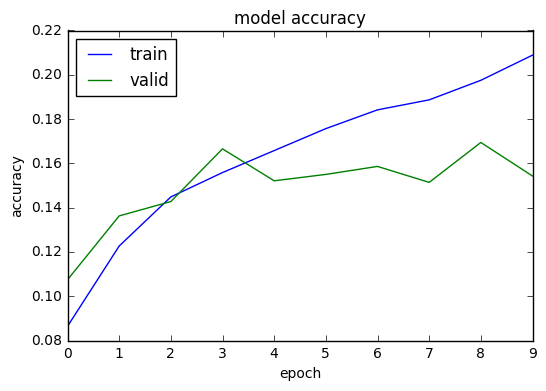

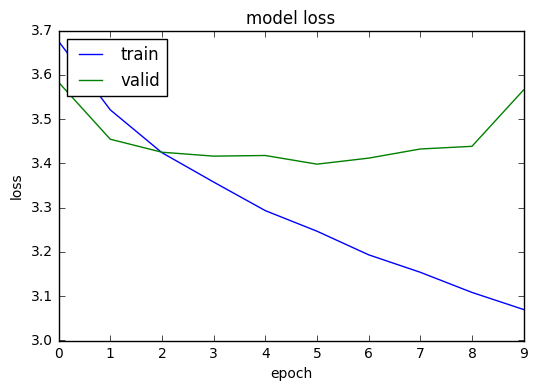

In [97]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

In [44]:
def save_model(model, model_name):
    # Генерируем описание модели в формате json
    model_json = model.to_json()
    # Записываем модель в файл
    json_file = open("model/{}_model.json".format(model_name), "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights("model/{}_weights.h5".format(model_name))
    print('Модель и веса успешно сохранены!')

In [58]:
save_model(model, 'vk_98percent_cnn')

Модель и веса успешно сохранены!
